<a href="https://colab.research.google.com/github/smaamehm/CapsNet-Tensorflow/blob/master/pytorch_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from numpy  import array
pilTrans = transforms.ToPILImage()
plt.ion()   # interactive mode

In [0]:
corpus_name = "hymenoptera_data"
data_dir = os.path.join("/content/gdrive/My Drive/data", corpus_name)

In [3]:
#Load Data
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '/home/aamir/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(type(image_datasets))
print (dataset_sizes)
print(class_names)
#Visualize a few images

<class 'dict'>
{'train': 244, 'val': 153}
['ants', 'bees']


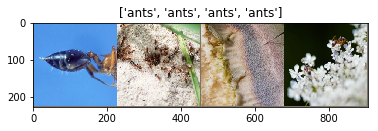

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

fig = plt.figure()
images_so_far = 0
'''with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(20 // 2, 2, images_so_far)
            ax.axis('off')
            imshow(inputs.cpu().data[j])
            print (images_so_far)'''

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Decay LR by a factor of 0.1 every 7 epochs
Epoch 0/4
----------
itr_epoch 1
itr_phase 1
itr_input 1
itr_input 2
itr_input 3
itr_input 4
itr_input 5
itr_input 6
itr_input 7
itr_input 8
itr_input 9
itr_input 10
itr_input 11
itr_input 12
itr_input 13
itr_input 14
itr_input 15
itr_input 16
itr_input 17
itr_input 18
itr_input 19
itr_input 20
itr_input 21
itr_input 22
itr_input 23
itr_input 24
itr_input 25
itr_input 26
itr_input 27
itr_input 28
itr_input 29
itr_input 30
itr_input 31
itr_input 32
itr_input 33
itr_input 34
itr_input 35
itr_input 36
itr_input 37
itr_input 38
itr_input 39
itr_input 40
itr_input 41
itr_input 42
itr_input 43
itr_input 44
itr_input 45
itr_input 46
itr_input 47
itr_input 48
itr_input 49
itr_input 50
itr_input 51
itr_input 52
itr_input 53
itr_input 54
itr_input 55
itr_input 56
itr_input 57
itr_input 58
itr_input 59
itr_input 60
itr_input 61
train Loss: 0.7439 Acc: 0.8975
itr_phase 2
itr_input 1
itr_input 2
itr_input 3
itr_input 4
itr_input 5
itr_input 6
itr_input 7
i

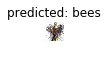

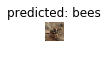

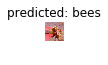

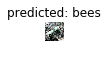

label tensor([0, 0, 0, 0])


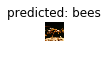

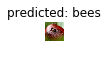

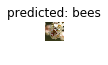

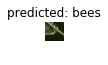

label tensor([0, 0, 0, 0])


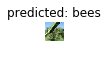

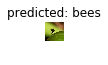

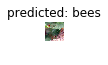

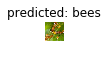

label tensor([0, 0, 0, 0])


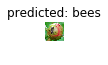

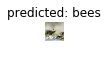

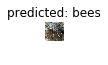

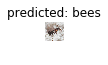

label tensor([0, 0, 0, 0])


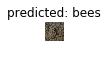

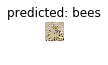

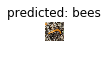

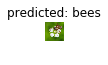

In [5]:
#Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    itr_epoch = 0
    itr_phase = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        itr_epoch += 1
        print('itr_epoch',itr_epoch)
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            itr_input = 0
            itr_phase += 1
            print('itr_phase', itr_phase)
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                #print('label', labels)
                itr_input += 1
                print('itr_input', itr_input)
                #inputs = inputs.(device)
                #labels = labels.(device)
                #zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #print('labels',labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #print('running',running_corrects, running_loss)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#Visualizing the model predictions
def visualize_model(model, num_images=20):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            #inputs = inputs.to(device)
            #labels = labels.to(device)
            print ('label', labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

print ('Decay LR by a factor of 0.1 every 7 epochs')
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft,criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)
visualize_model(model_ft)